# Causal Impact

## Import libraries

In [1]:
#!pip install matplotlib seaborn scikit-learn causalinference psmpy

In [2]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')
from sklearn.preprocessing import StandardScaler
from causalinference import CausalModel
from psmpy import PsmPy
from scipy import stats as st
import joblib
from scipy.stats import norm, ttest_ind
from tqdm import tqdm
from joblib import Parallel, delayed

## Importing data

In [3]:
df = pd.read_csv('dataset_for_psm_hw.csv')

In [4]:
df

,Unnamed: 0,price,year,floor,rooms,square,revenue,treatment,id
0,0,16500000.00,2009,17.00,1,39,0.00,0.00,0
1,1,23000000.00,2021,5.00,1,45,0.00,0.00,1
2,2,44700000.00,2015,4.00,2,79,0.00,1.00,2
3,3,10500000.00,2011,23.00,1,30,0.00,1.00,3
4,4,40000000.00,2022,5.00,2,71,0.00,0.00,4
...,...,...,...,...,...,...,...,...,...
20368,20368,19000000.00,2022,4.00,1,41,0.00,1.00,20368
20369,20369,17500000.00,1969,2.00,2,40,0.00,0.00,20369
20370,20370,21000000.00,2023,5.00,1,38,0.00,1.00,20370
20371,20371,82500000.00,2022,12.00,3,91,0.00,0.00,20371


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20373 entries, 0 to 20372
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20373 non-null  int64  
 1   price       20373 non-null  float64
 2   year        20373 non-null  int64  
 3   floor       20373 non-null  float64
 4   rooms       20373 non-null  int64  
 5   square      20373 non-null  int64  
 6   revenue     20373 non-null  float64
 7   treatment   20373 non-null  float64
 8   id          20373 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 1.4 MB


In [6]:
df.treatment.value_counts(normalize=True)

0.00   0.61
1.00   0.39
Name: treatment, dtype: float64

## Tasks

### Task 1.

 **Specify the absolute difference between the means for the parameter 'square' (difference for ads that used treatment and did not).**

In [7]:
sqaure_min_control = df[df['treatment'] == 0].square.mean()
sqaure_min_treatment = df[df['treatment'] == 1].square.mean()

In [8]:
np.abs(sqaure_min_treatment - sqaure_min_control)

8.082047676335662

### Task 2.  

**Specify the standardized difference of Cohen's D effect size, where the standard deviation is the std of the entire dataframe for this metric.** 

In [9]:
std_ = df.square.std()

In [10]:
uplift = df[df['treatment'] == 1].square.mean() - df[df['treatment'] == 0].square.mean()

In [11]:
d = uplift / std_

print(d)

0.1995869024588606


### Task 3. 

**What percentage of ids are having treatment?** 

In [12]:
df.treatment.mean()

0.39203848230501154

### Task 4. 

**Specify the standardized difference of Cohen's D effect size, where the standard deviation is the std of the entire dataframe for the `revenue` metric.**

In [13]:
std_ = df.revenue.std()

In [14]:
uplift = df[df['treatment'] == 1].revenue.mean() - df[df['treatment'] == 0].revenue.mean()

In [15]:
d = uplift / std_

print(d)

0.06544894156840587


### Task 5. 

**Are treatment and control groups representative?**

In [16]:
df.columns

Index(['Unnamed: 0', 'price', 'year', 'floor', 'rooms', 'square', 'revenue',
       'treatment', 'id'],
      dtype='object')

In [17]:
features = ['price', 'year', 'floor', 'rooms', 'square', 'revenue']

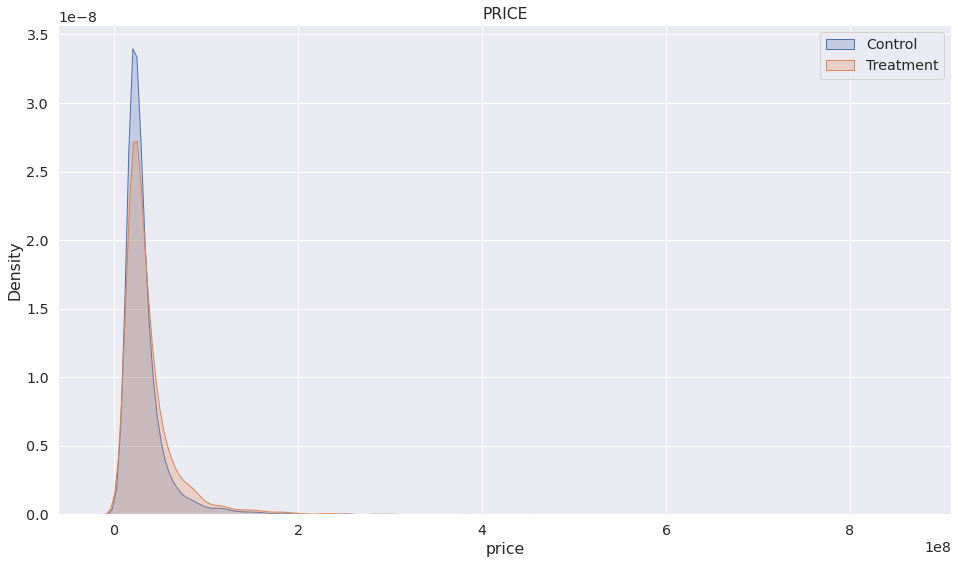

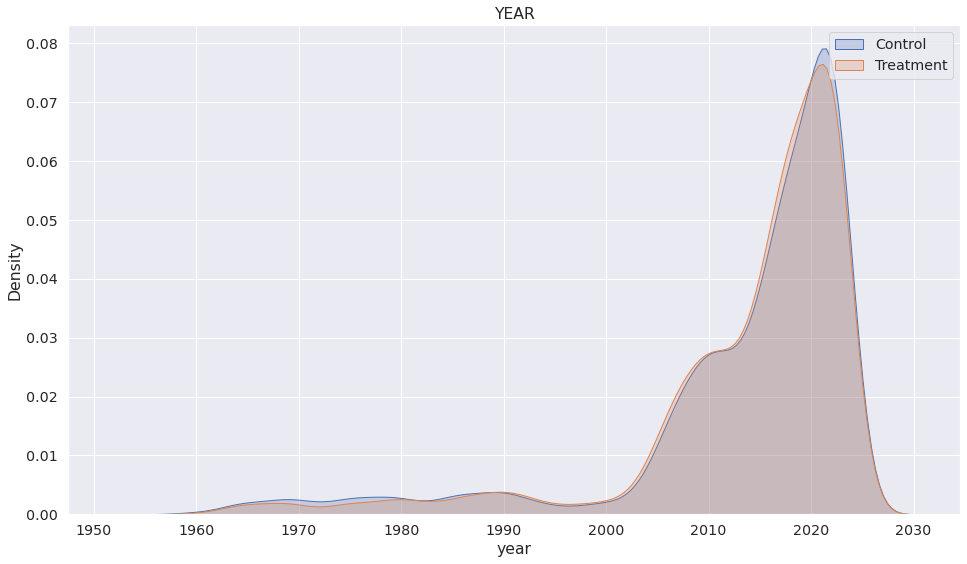

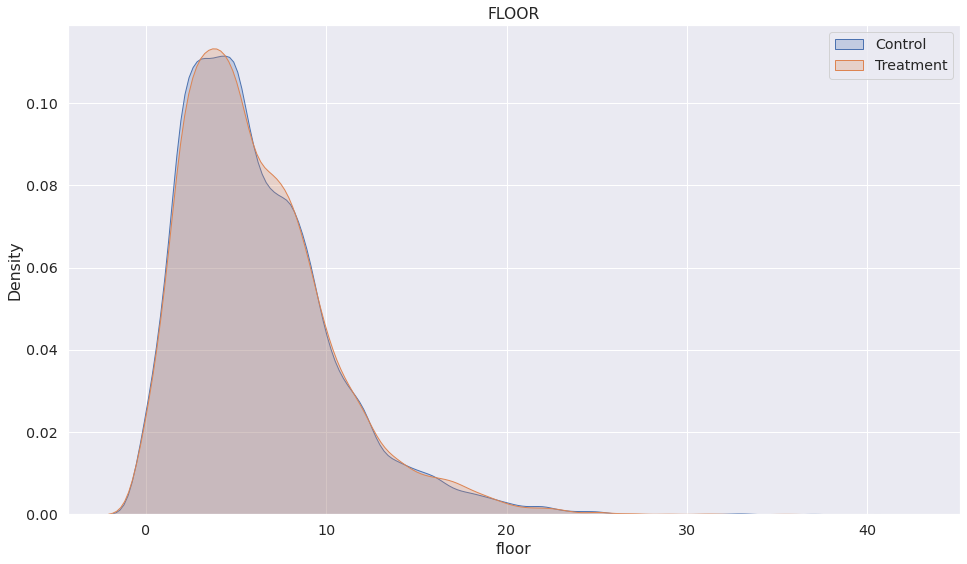

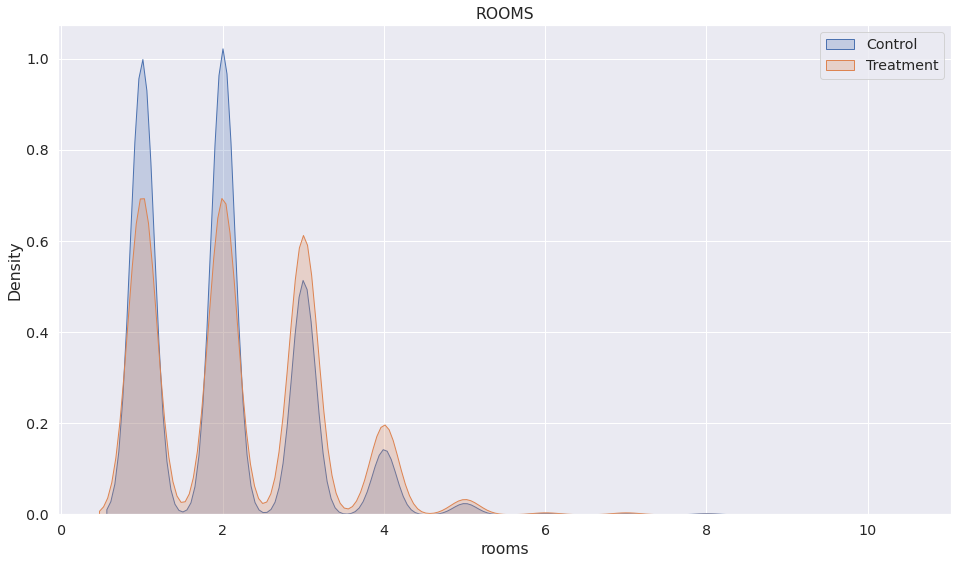

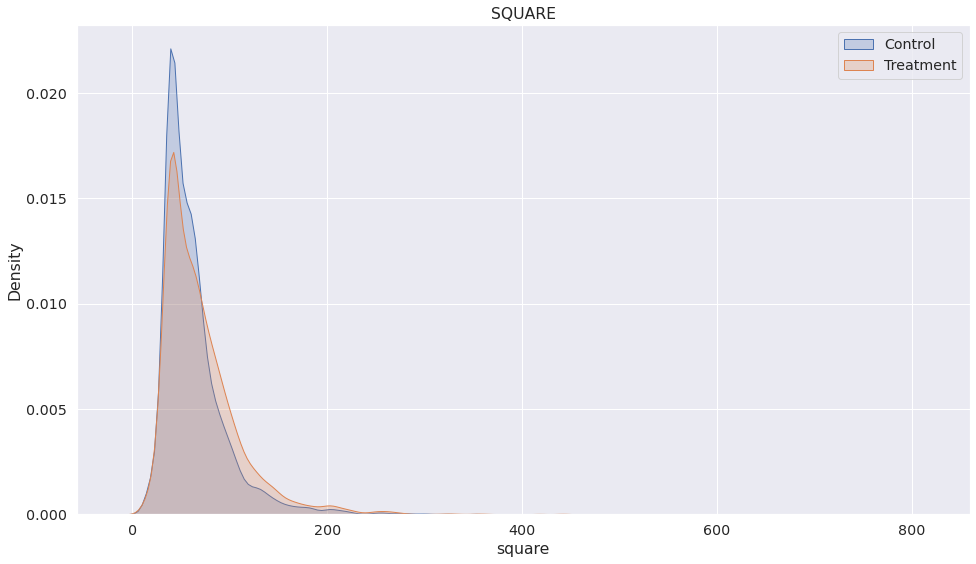

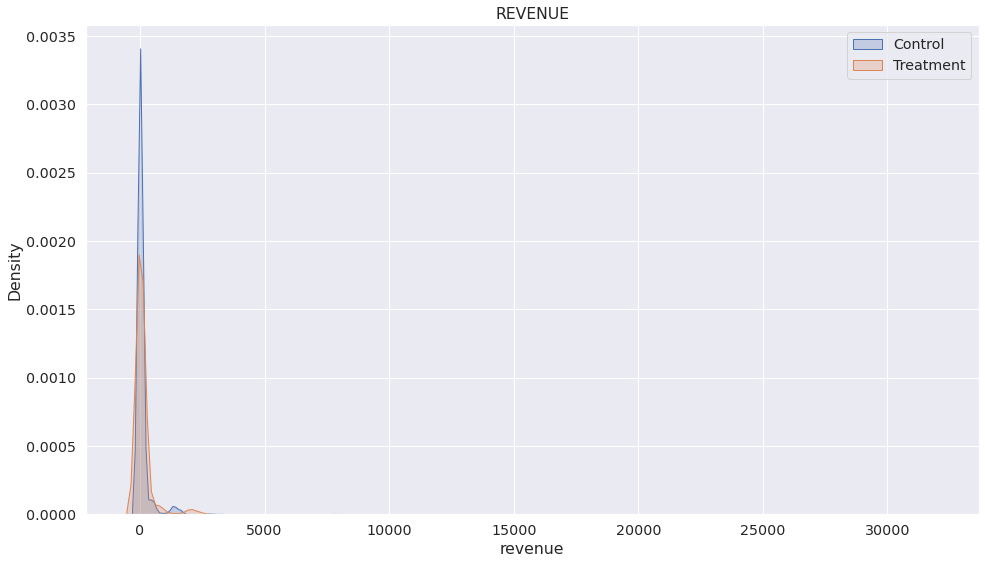

In [18]:
for feature in features:
    fig, ax = plt.subplots(1, 1, figsize = (16, 9))
    sns.kdeplot(data = df[df['treatment'] == 0], x = feature, label = 'Control', fill=True)
    sns.kdeplot(data = df[df['treatment'] == 1], x = feature, label = 'Treatment', fill=True)
    plt.title(f'{feature.upper()}')
    plt.legend()

We cannot use the treatment and control groups as they are to compare them. There are discrepancies in the observable parameters, the groups differ, and this may be distorting the effect.

### Task 6. 

**What "raw" effect (difference between treatment and control) does the model see in the data?**

In [19]:
%%time

y = df['revenue'].values
t = df['treatment'].values
X_ = df[['price', 'year', 'floor', 'rooms', 'square']]
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_), 
                 columns=X_.columns).values
model = CausalModel(y, t, X_scaled) 
print(model.summary_stats)
model.est_propensity() # propensity score estimate

propensity_score = model.raw_data['pscore']
propensity_score = np.where(propensity_score==1, 0.9999999999, propensity_score)

a = propensity_score
b = 1 - propensity_score
c = a / b
propensity_logit = pd.DataFrame(np.log(c)).replace(np.inf, 0).values # converting to propensity_logit

model = CausalModel(y, t, propensity_logit) # causal model
model.est_via_matching()
print(model.estimates)


Summary Statistics

                     Controls (N_c=12386)        Treated (N_t=7987)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y      105.143      700.598      162.644     1098.105       57.502

                     Controls (N_c=12386)        Treated (N_t=7987)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       -0.058        0.941        0.091        1.079        0.147
             X1       -0.011        1.030        0.016        0.952        0.027
             X2       -0.006        1.000        0.009        1.000        0.015
             X3       -0.090        0.954        0.140        1.053        0.229
             X4       -0.078        0.948        0.121        1.065        0.198


Trea

### Task 7. 

**What is p-value for ATE?**

In [20]:
metric = 'ate' 

model_estimates = model.estimates.get('matching')
z = model_estimates.get(metric) / model_estimates.get(metric+'_se')
p_value_z = (1 - st.norm.cdf(abs(z))) * 2
print('z statistic =', z)
print('p-value =', p_value_z)

z statistic = 2.7121499441318893
p-value = 0.006684834630408254


### Task 8. 

**What is p-value for ATT?**

In [21]:
metric = 'att' 

model_estimates = model.estimates.get('matching')
z = model_estimates.get(metric) / model_estimates.get(metric+'_se')
p_value_z = (1 - st.norm.cdf(abs(z))) * 2
print('z statistic =', z)
print('p-value =', p_value_z)

z statistic = 1.4793156956040152
p-value = 0.13905595989021813
